# Preliminary Analysis of Computational Needs for NISAR Offset Tracking

Speckle tracking is a numerically intensive operation and further analysis is required to determine if these operations can be done most efficently with a CPU- or GPU-based architecture. Even on basic CPUs there are a lot of benchmarks in the NISAR community that span wide range of speeds. This notebook is an attempt to understand how such differences arise.

## Normalized Cross Correlation (NCC)

In general,speckled tracking is accomplished by peforming a normalized cross correlation of a search chip from the first image ($I_1$) with a reference window from the second image ($I_2$). Figure 1 shows the basic matching geometry. The data are cross-correlated using a search chip of size, $W_{\rho}$, pixels in range by $W_{s}$ pixels in azimuth centered about a point in the reference image $\left( \rho_{2},s_{2} \right)$. Offsets are computed relative to a reference point $\left( \rho_{1},s_{1} \right)$ by cross correlating over a search distance, $S_{\rho}$, pixels in range by, $(S_{s}$, pixels in azimuth. 

<img src="./CrossCorrelationFigure.png" style="width: 700px"/>

Thus the correlation function is computed as

$$\Gamma_{C}\left( \delta_{\rho},\delta_{s},\rho_{1},s_{1} \right) = \frac{\frac{1}{W_{\rho}W_{s}}\sum\limits_{\rho = - W_{\rho}/2}^{\rho = W_{\rho}/2}{\sum\limits_{s = {- W}_{s}/2}^{s = W_{s}/2}{f\left( \rho_{1},s_{1} \right)I_{1}({\rho + \rho}_{1} - \delta_{\rho},{s + s}_{1} - \delta_{s})I_{2}^{*}({\rho + \rho}_{1} + \tau_{\rho},{s + s}_{1} + \tau_{s})}}}{\sigma_{1}(\delta_{\rho},\delta_{s}\rho_{1},s_{1})\sigma_{2}(\rho_{1},s_{1})}$$

where

$$\sigma_{1}\left( \delta_{\rho},\delta_{s},\rho_{1},s_{1} \right) = \frac{1}{\sqrt{W_{\rho}W_{s}}}\sqrt{\sum_{\rho = - W_{\rho}/2}^{\rho = W_{\rho}/2}{\sum_{s = -W_{s}/2}^{s = W_{s}/2}\left| I_{1}({\rho + \rho}_{1} - \delta_{\rho},{s + s}_{1} - \delta_{s}) \right|^{2}}}$$ <br />
and<br />
$$\sigma_{2}\left( \rho_{1},s_{1} \right) = \frac{1}{\sqrt{W_{\rho}W_{s}}}\sqrt{\sum_{\rho = - W_{\rho}/2}^{\rho = W_{\rho}/2}{\sum_{s = -W_{s}/2}^{s = W_{s}/2}\left| I_{2}({\rho + \rho}_{1},{s + s}_{1}) \right|^{2}}}$$<br />
with<br />$$\left| \delta_{\rho} \right| \leq S_{\rho}$$ and $$\left| \delta_{s} \right| \leq S_{s}$$

In this equation, $f\left( \rho_{1},s_{1} \right)$ is weighting function, which for amplitude matching is always equal to 1.  In these equations, $(\tau_{\rho})$ and $(\tau_{s})$ are initial estimates of the offset between the first and second image. This initial guess may be dead reckoned from the orbital information, from an initial co-registration procedure, or from knowledge of the velocity field (i.e., a pre-existing velocity map.) This equation is written so that it could apply to either complex or amplitude data. Note the limits on the summation strictly should be $-W/2-1$ if the window width is an even value. For the purposes of analysis such differences are not signficant, but care should be taken if these equations are implmented.

Once $\Gamma_{C}\left( \delta_{\rho},\delta_{s},\rho_{1},s_{1} \right)$ is
computed for a point, the peak is located, which is provides the integer-valued offsets value. To get sub-pixel resolution the area
around the peak is oversampled, often by a factor of ~20. A sinc-interpolator generally provides better results than polynomial based interpolation. Once the integer offset has been determined, roughly the same oversampling operation applies no matter what the window size or search radius is. Since it represents a cost common to all estimates, we don't explicitly evaluate it here. 


## Direct Correlaton Computational Cost

For simplicity, we will examine the computational cost assuming a square search window of width, $W$, with a common search radius, $\delta$ , for both dimensions. For now we are considering only amplitude matching. The numerator in the $\Gamma_{C}$ represents a convolution so that each point (assuming $f=1$) there are $W^2$ multiply-accumulate operations. For a search radius of $\delta$, this operation must be carried out $(2\delta+1)^2$ times, for a total of $W^2 (2\delta+1)^2$. There is a cost associated with computing the squared absolute values, but for now will neglect those computations (for the search window this amounts to $W^2$ multiplies and another $(W+2\delta+1)^2$ for the reference window). 

For the denominator the search window $\sigma_2$ only needs to be computed once, yielding $W^2$ multiply/accumulate operations. For $\sigma_1$, however, the summation has to be performed for each offset increment. With an efficient implementation, there are $W^2$ multiply-accumulate operations to start, but each subsequent shift by $\delta$ in either direction can be computed as 2$W$ multiply-accumulate operations. With this method moving to the right by $\delta$, the algorithm would substract $W$ values from the left size of the window, and add $W$ more value to right, for a total of $2W$ floating point operations. As a result, total number of additions are for the denominator are $(2\delta)^2 2 W$. If we make a rough assumption that the cost of floating point multiplies, multiply-accumulate, and additions are the same, then the direct cost for NMC computation is
$$FLOPS_D = W^2 (2\delta+1)^2 + 2W^2 + (2\delta)^2 2 W$$ 
Note in the interest of simplicity, this equation neglects more numperically more expensive but much less used floating point operations of division and sqrt. We can implement this equation as:

In [1]:
def NCCDenominator(W, delta):
    return W**2 + 8 * delta**2 * W

def directCorrelation(W, delta):
    return W**2 * (2 * delta + 1)**2 + NCCDenominator(W, delta)

Using this function, we can compute the cost for a variety of search radii and window sizes.

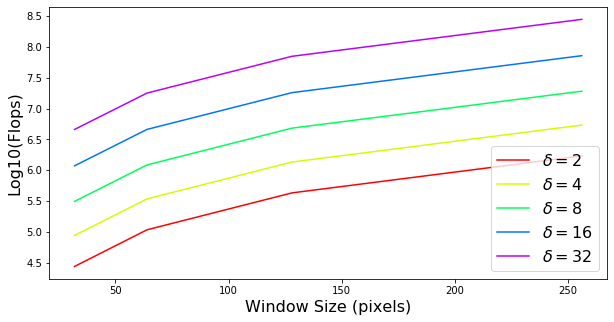

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
deltas = [2, 4, 8, 16, 32]
windows = [32, 64, 128, 256]
myColors = cm.get_cmap('hsv', len(deltas)+1)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for delta, myColor in zip(deltas, myColors(range(0,len(deltas)))):
    ax.plot(windows, np.log10([directCorrelation(W, delta) for W in windows]), color=myColor, label=f'$\delta=${delta}')
plt.xlabel('Window Size (pixels)', fontsize=16)
plt.ylabel('Log10(Flops)', fontsize=16)
plt.legend(fontsize=16)

**Figure 2. Log of Flops as a function of window size for representative search radii.**

While the results shown don't provide absolute times, the relative sensitivity to search radius and window size is clearly apparent. While the results may be relatively fast for a small window and limited search radius, it easy to increase the computational load by 4 orders of magnitudes for radius/window combinations that are not outside of the range that might be expected to be encountered for typical speckle tracking operations. Thus, a brute force approach can quickly become cost prohibitive.

## FFT-Based NCC

Fast Fourier Transforms (FFTs) can greatly reduce computational expense. The numerator of the NCC equation is essentially the convolution $I_1 * I_2$. Using Fourier transforms, this operation can be performed as 
$$\mathcal{F}(I_1 * I_2) = \mathcal{F}(I_1) \cdot \mathcal{F}(I_2),$$ which means $$I_1 * I_2 = \mathcal{F}^{-1}(\mathcal{F}(I_1) \cdot \mathcal{F}(I_2))$$

There are a couple of important points. First, while the complete convolution is peformed, it is a ciruclar convolution such as the sides and top wrap around. As long as the search chip is expanded to the same size as the reference chip by zero padding (e.g. cyan region in Figure 1), then result will be identical to the direct computation of the numerator in the NCC equation. For the numerator, the normalization has to be directly computed (or via a separate FFT with a mask for the reference window). Generally FFTs reduce the computational burden from $N^2$ in each direction to $Nlog(N)$ in one dimension. One estimate of a lower bound for the floating point adds and multiplies is $~34/9 N log_{2}(N)$. For the 2D case, this equation becomes $~34/9 N^2 log_{2}(N^2)$. Actual performance can vary based on the exact FFT implementation, but as long as care is used on the selection of the algorithm, the results shoudl not differ to significantly. Whatever the constant is for the exact algorithm, the results shown here are indicative of relative performance. 

So as in the example above, $N = W + 2\delta + 1$. Two foward and one reverse transforms are required so that the cost for a 2D convolution is: $$FLOPS_{FFT} = 3(34/9 * N^2 * log_2(N^2)) + 2W^2 + (2\delta)^2 2 W$$

This function can be computed as:

In [3]:
def fftCost(N1D):
    N2D = N1D * N1D
    return (34./9) * N2D * np.log2(N2D)

def fftCrossCorrelation(W, delta):
    N = (W + 2.0 * delta + 1.0)
    return 3.0 * fftCost(N) + NCCDenominator(W, delta)

Keeping in mind that any of these calcuations could easily be off by more than a factor of 2, we can then compare an FFT based approach with the direct computation with the following code.

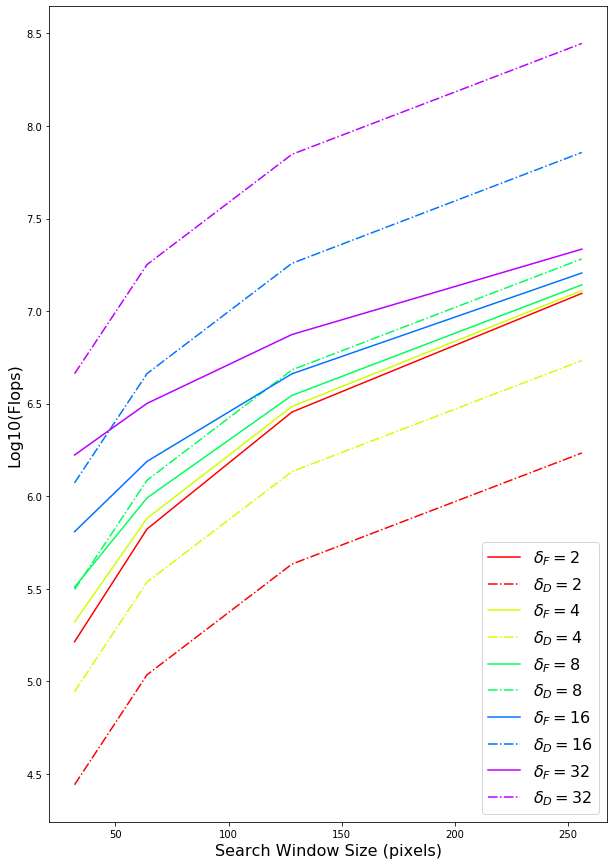

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10,15))
for delta, myColor in zip(deltas, myColors(range(0,len(deltas)))):
    ax.plot(windows, np.log10([fftCrossCorrelation(W, delta) for W in windows]), color=myColor, label=f'$\delta_F=${delta}')
    ax.plot(windows, np.log10([directCorrelation(W, delta) for W in windows]),color=myColor, linestyle='-.',label=f'$\delta_D=${delta}')
plt.xlabel('Search Window Size (pixels)', fontsize=16)
plt.ylabel('Log10(Flops)', fontsize=16)
plt.legend(fontsize=16)

**Figure 3. Comparison of FFT and direct computation approaches to computing NCC.**

The results in Figure 3 illustrate the for small search radii (< 4) direct computation is faster. But as soon the search radii exceeds 8, the FFT approach is the fastest. 

## Oversampled FFT

Because of the non-linearity in the process of detecting the image, strictly speaking the data should be oversampled by a factor of two to avoid spectral aliasing. Futher work to quantify the improvement in peformance is needed to determine whether it justifies the increase computational expense. The oversample does reduce the load on the oversampling of the correlation peak. Oversampling can be performed by FFTing the data, doubling the size of the spectral window, and zero padding the outer portions of the bands. This requires 4 additional FFTs. It also requires that the other transforms are all twice as large. Thus for the oversampled case: $$FLOPS_{OS} = 5((34/9) (2N)^2 log_2(4N^2) + 2(34/9 N^2 log_2(N^2) + 4(2W^2 + (2\delta)^2 2 W)$$

In [5]:
def fftCrossCorrelationOS(W, delta):
    N = (W + 2.0 * delta + 1.0)
    NOS = 2.0 * N
    return 5.0 * fftCost(NOS) + 2 * fftCost(N) +  4 * NCCDenominator(W, delta)

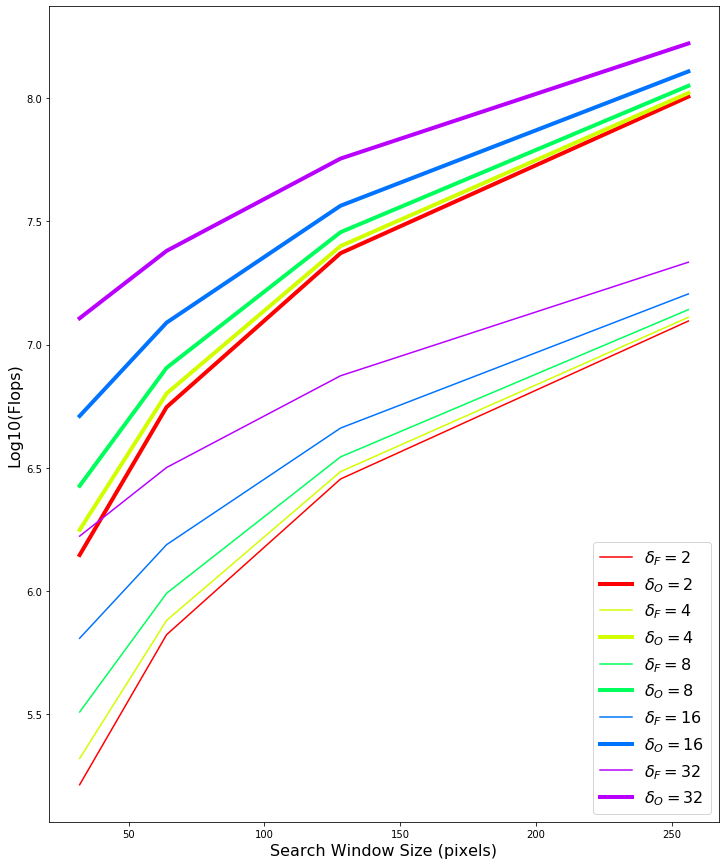

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,15))
for delta, myColor in zip(deltas, myColors(range(0,len(deltas)))):
    ax.plot(windows, np.log10([fftCrossCorrelation(W,delta) for W in windows]), color=myColor, label=f'$\delta_F=${delta}')
    ax.plot(windows, np.log10([fftCrossCorrelationOS(W,delta) for W in windows]), color=myColor, linewidth=4,label=f'$\delta_O=${delta}')
plt.xlabel('Search Window Size (pixels)', fontsize=16)
plt.ylabel('Log10(Flops)', fontsize=16)
plt.legend(fontsize=16)

**Figure 4. Comparison of speed for NCC with ($\delta_O$) and without ($\delta_F$) oversampling.**

## Caveats

There are several caveats to the above analysis:
* The estimates of FLOPS are fairly crude. For example, for the direct computation modern processors are assumed to be able to do a multiply accumulate operation as fast as a single multiply or add. By contrast, the FFT formula appears to represent all FLOPS (adds and multiplies seperately). So depending on the archtecture, the direct computation could be a factor of 2 to fast or the FFT method a factor 2 too slow.
* The analysis assumes a generic FFT. For the foward transforms, however, the result should be quicker because the data are real valued, which should speed up some of the transforms by approximately a factor of 2.
* The integer operations associated with loops to carry out the FLOPs have been ignored, as have the more expensive but less abundent sqrt and division operations.
* The bottom line is this analysis serves as a guide of what to expect for relative peformance for the different methods. But there is enough uncertainty associated with the actual implementation that it can not serve as a substitute for rigorous benchmarking. 

## Discussion

The examples above make several important points:
* When comparing direct correlation with FFT based correlation neither method is always the best. 
* Generally ice sheets require larger search radii, which means FFTs are required for much of the ice sheet.
* Signicant computational savings still might be realized for slow moving areas with direct computation if the initial offsets can be constrained well enough to use $\delta <=4$.  
* Oversampling increases the cost of NCC by nearly an order of magnitude (~8X). 
* Doubling window size yields nearly half an order of magnitude increase in computational cost ~(2-3x). 

While FFTs are generally preferred, small windows and search radii should run faster with direct computation. It was these types of offsets that the original AMPCORR was coded, which is why the direct computation approach was adopted. A hybrid approach might make sense for ice sheets if the exact method can be determined on the fly for each offset location. 

Oversampling definitely ups the computational cost, though a small percentage of this cost is recovered when oversampling the peak. Best results are achieved with overlapping offsets (e.g., offsets every 24 pixels, with a 64 pixel search window). In the calculation described, the data are assumed to oversampled for each match. With such redundancy, significant savings could realized by oversampling the full image before applying the matching procedure. The total cost would be then that of resampling the image + ~60% of the original match cost. Total savings would depend on the amound of redundancy (e.g., how many times each image pixel was used in a matching operation.)

While strictly speaking the oversampling operation should be applied, matches are still obtained if this operation is not peformed. What's not clear is the loss of quality enough to justify the increase in speed. More analysis is need to determine the best approach. 

Another approach that can sacrifice performance to improve speed to use FFT methods, but ignore the wraparound effects. If the offsets < 1, this would effectively cause no error. For offsets of a few pixels, the wrap around effects degrade correlation, which will degrade the overall match quality. This operation reduces makes use of smaller windows and avoids the need to recompute the NCC denominatory. The cost of this operation is: $$FLOPS_{Circular} = 5((34/9) (2W)^2 log_2(4W^2) + 2(34/9 W^2 log_2(W^2) + 2W^2$$

In [7]:
def fftCrossCorrelationCirc(W):
    # assumes oversampling
    N = W
    NOS = 2.0 * N
    return 5.0 * fftCost(NOS) + 2 * fftCost(N) +  2 * W**2
W, delta = 64, 8
print(f'Circular convolution speedup for W={W}, delta={delta}: {fftCrossCorrelationOS(W,delta)/fftCrossCorrelationCirc(W):,.1f}')

Circular convolution speedup for W=64, delta=8: 1.7


For areas where a velocity map can get the estimate within a few pixels, this method can offer siginficant speedup up with relatively little degradation.

To compare the results with some real world benchmarks, the current implementation of AMPCORR takes 720 CPU minutes (90 minutes x 8 cores) for a job that runs on autoRIFT in 10 minutes, for a 72x speedup. Roughly 2/3 of the results for the autoRIFT example use 32 pixel windows with no overampling with the rest using 64 pixel windows. Its not clear what the ampcorr parameters are, but a search window of about 18 pixels would be needed to capture the full range of motion and a uniform search window of at least 64 pixels. In this case, the difference between the two methods would be:

In [8]:
W1, W2 = 64, 32
deltaAC, deltaAR = 20, 4
print(f'autoRift Speedup: {fftCrossCorrelationOS(W1, deltaAC) / (0.66*fftCrossCorrelation(W2, deltaAR) + 0.34 * fftCrossCorrelation(W1, deltaAR)):.01f}')

autoRift Speedup: 37.3


Even with rough guesses at the parameters, the estimate is within about a factor two of the actual result. Additional differences could be less than 100% efficiency in the AMPCORR parallism. A single CPU to single CPU example would make for a better comparison. Nonetheless, the results suggest that the computations above are provide a reasonable estimate of peformance that can be used to guide speckle tracking development.

Complex cross correlation has not been considered here. Where it works, complex cross correlation can achieve similar performance to larger windows. The computations above assume generic FFTs. As the correlation runs on the undetected data there is no need for oversampling. Where it works (a low fringe rate is needed), a 24-pixel window can be used with similar peformance to that 64-pixel amplitude window. This offers an approximate speedup of:

In [9]:
Wamp, Wcmpx = 64, 24
delta = 4
print(f'Complex matching speedup with W={Wcmpx} relative to amplitude with W={Wamp} and delta={delta}:  {fftCrossCorrelationOS(Wamp, delta)/fftCrossCorrelation(Wcmpx, delta):.0f}')

Complex matching speedup with W=24 relative to amplitude with W=64 and delta=4:  49


A hanning weighting to reduce the wrap around effects can be used with circular convolution to obtain similar performance. This provides signicantly better noise performance relative to the W=24 no weighting (see offsets memo) and still provide >20x speedup relative to amplitude matching. 

In [10]:
Wamp, Wcmpx = 64, 48
delta = 4
def fftCrossCorrelationCircNoOS(N):
    return 3.0 * fftCost(N) + 2 * W**2
print(f'Complex Hanning window matching speedup with W={Wcmpx} relative to amplitude with W={Wamp} and delta={delta}:  {fftCrossCorrelationOS(Wamp, delta)/fftCrossCorrelationCircNoOS(Wcmpx):.0f}')

Complex Hanning window matching speedup with W=48 relative to amplitude with W=64 and delta=4:  21
